# Textract by AWS

Amazon Textract offers a variety of operations that apply to different documents\
In case rotation information is needed, [this](https://github.com/aws-samples/amazon-textract-response-parser/tree/master/src-python) repo could be useful

## Identifying usecase

- **Detecting text only**
- **Detecting and analyzing relationships between text**
- Detecting and analyzing text in invoices and receipts
- Detecting and analyzing text in government identity documents
- Detecting and analyzing text in lending documents

### Detecting Text

Following information is returned in **block objects**
- The lines and words of detected text
- The relationships between the lines and words of detected text
- The page that the detected text appears on
- The location of the lines and words of text on the document page

Bounding boxes [manual](https://docs.aws.amazon.com/textract/latest/dg/text-location.html)\
DetectDocumentText() detects text in the input document, returns array of **blocks**

Block - Geometry
- The location of the recognized text on the image. It includes an axis-aligned, coarse bounding box that surrounds the text, and a finer-grain polygon for more accurate spatial information.
- Type: Geometry object
- Required: No

### Analyzing Text

Dominant text orientation

Textract analysis operations return 5 categories of document extraction
- text
- forms
- tables
- query responses
- signatures

## Costs

Detect Document Text API - The cheapest API they offer:\
$1.50 per 1000 pages for the first million pages in a month\
0.15 cents per page\
pretty much free for the first three months\
viewing or drawing boxes with OpenCV/Matplotlib is local and free.

# First test

{'BlockType': 'LINE', 'Confidence': 99.55443572998047, 'Text': 'lo (undeclared)', 'Geometry': {'BoundingBox': {'Width': 0.02306998521089554, 'Height': 0.13946202397346497, 'Left': 0.8737123012542725, 'Top': 0.09121646732091904}, 'Polygon': [{'X': 0.8967822790145874, 'Y': 0.09121646732091904}, {'X': 0.8908994197845459, 'Y': 0.22939765453338623}, {'X': 0.8737123012542725, 'Y': 0.2306784987449646}, {'X': 0.8796144127845764, 'Y': 0.0925075113773346}]}, 'Id': 'a4731ca8-fdcd-4c52-a0cc-fcf6cf0c033f', 'Relationships': [{'Type': 'CHILD', 'Ids': ['346428c3-5141-41e5-afe9-015a20393a65', '830c14cf-8df2-4658-abc6-7db2a9ddb9f4']}]}
{'BlockType': 'LINE', 'Confidence': 99.49296569824219, 'Text': 'lo (undeclared)', 'Geometry': {'BoundingBox': {'Width': 0.023153338581323624, 'Height': 0.13959650695323944, 'Left': 0.6038404107093811, 'Top': 0.034315966069698334}, 'Polygon': [{'X': 0.626993715763092, 'Y': 0.034315966069698334}, {'X': 0.6207901239395142, 'Y': 0.17264290153980255}, {'X': 0.6038404107093811,

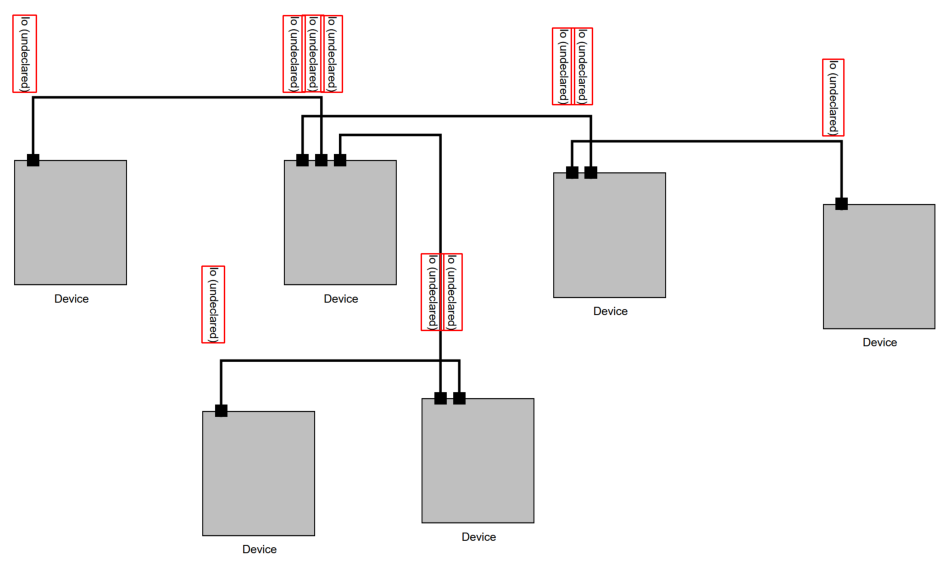

In [1]:
import cv2
import boto3
import matplotlib.pyplot as plt

# load image and convert to RGB
path = 'images/testcase5.png'
image_bgr = cv2.imread(path)
height, width, _ = image_bgr.shape
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# read image bytes
with open(path, 'rb') as img_file:
    img_bytes = img_file.read()

# call AWS textract
client = boto3.client('textract', region_name='eu-central-1')
response = client.detect_document_text(Document={'Bytes': img_bytes})

# bounding boxes are returned as ratio of the overall image size
for item in response['Blocks']:
    if item['BlockType'] == 'LINE': # can also be 'WORD' if the words should not be detected seperately
        box = item['Geometry']['BoundingBox']
        left = int(width * box['Left'])
        top = int(height * box['Top'])
        box_width = int(width * box['Width'])
        box_height = int(height * box['Height'])
        cv2.rectangle(image_rgb, (left, top), (left + box_width, top + box_height), (255, 0, 0), 2)  # red in BGR
        print(item) # ['Text']

# display the bounding boxes
plt.figure(figsize=(12, 12))
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

# Implementation

In [ ]:
import cv2
import boto3
import numpy as np
import matplotlib.pyplot as plt
from math import cos, sin, pi

# Initialize Textract client
textract = boto3.client('textract')

def pad_image_to_square(image):
    h, w = image.shape[:2]
    if h == w:
        return image
    size = max(h, w)
    padded_image = cv2.copyMakeBorder(image, 
                                      top=(size - h) // 2,
                                      bottom=(size - h + 1) // 2,
                                      left=(size - w) // 2,
                                      right=(size - w + 1) // 2,
                                      borderType=cv2.BORDER_CONSTANT,
                                      value=[255, 255, 255])
    return padded_image

def rotate_image(image, angle):
    (h, w) = image.shape[:2]
    center = (w / 2, h / 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, M, (w, h))

def rotate_point(point, angle, center):
    angle_rad = -angle * (pi / 180.0)
    ox, oy = center
    px, py = point
    qx = ox + (px - ox) * cos(angle_rad) - (py - oy) * sin(angle_rad)
    qy = oy + (px - ox) * sin(angle_rad) + (py - oy) * cos(angle_rad)
    return [int(qx), int(qy)]

def call_textract(image_bgr):
    _, encoded_img = cv2.imencode('.png', image_bgr)
    response = textract.detect_document_text(Document={'Bytes': encoded_img.tobytes()})
    return response

def extract_textract_boxes(response, shape, angle=0):
    h, w = shape[:2]
    boxes = []

    for item in response['Blocks']:
        if item['BlockType'] == 'LINE':
            box = item['Geometry']['BoundingBox']
            left = int(w * box['Left'])
            top = int(h * box['Top'])
            width = int(w * box['Width'])
            height = int(h * box['Height'])
            right = left + width
            bottom = top + height
            bbox = [[left, top], [right, top], [right, bottom], [left, bottom]]

            if angle != 0:
                center = (w // 2, h // 2)
                bbox = [rotate_point(p, -angle, center) for p in bbox]

            boxes.append([bbox, item['Text'], float(item.get('Confidence', 100.0))])
    return boxes

def adjust_text_box_positions(result, image_shape):
    h, w = image_shape[:2]
    size = max(h, w)
    pad_top = (size - h) // 2
    pad_left = (size - w) // 2
    for detection in result:
        for point in detection[0]:
            point[0] -= pad_left
            point[1] -= pad_top
    return result

def boxes_overlap(box1, box2):
    x1 = max(min(pt[0] for pt in box1), min(pt[0] for pt in box2))
    y1 = max(min(pt[1] for pt in box1), min(pt[1] for pt in box2))
    x2 = min(max(pt[0] for pt in box1), max(pt[0] for pt in box2))
    y2 = min(max(pt[1] for pt in box1), max(pt[1] for pt in box2))
    return x2 > x1 and y2 > y1

def remove_overlapping_boxes(results):
    to_remove = set()
    for i in range(len(results)):
        for j in range(i + 1, len(results)):
            if boxes_overlap(results[i][0], results[j][0]):
                to_remove.add(j)
    return [r for idx, r in enumerate(results) if idx not in to_remove]

def draw_boxes(image, results):
    for bbox, text, conf in results:
        cv2.polylines(image, [np.array(bbox, dtype=np.int32)], isClosed=True, color=(0, 255, 0), thickness=2)
        cv2.putText(image, text, tuple(bbox[0]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
    return image

# --- Load and process your image ---
image_path = 'your_image.png'  # Update with your image path
original_image = cv2.imread(image_path)
padded_image = pad_image_to_square(original_image)

# Run Textract on original and rotated
response_orig = call_textract(padded_image)
results = extract_textract_boxes(response_orig, padded_image.shape, angle=0)

rotated_img = rotate_image(padded_image, 90)
response_rot = call_textract(rotated_img)
results_rot = extract_textract_boxes(response_rot, rotated_img.shape, angle=90)

# Combine and adjust
results.extend(results_rot)
results = adjust_text_box_positions(results, original_image.shape)
results = remove_overlapping_boxes(results)

# Draw results
image_with_boxes = original_image.copy()
image_with_boxes = draw_boxes(image_with_boxes, results)

# Convert BGR to RGB for displaying in notebook
image_rgb = cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(image_rgb)
plt.axis('off')
plt.title("Text Detections with Textract")
plt.show()
